In [14]:
# combined nyc taxi data from March and April 2024
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
taxi_mar = pd.read_parquet('yellow_tripdata_2024-03.parquet')
taxi_apr = pd.read_parquet('yellow_tripdata_2024-04.parquet')
taxi_combined = pd.concat([taxi_mar, taxi_apr], ignore_index=True)
taxi_combined.to_csv('yellow_tripdata.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'yellow_tripdata_2024-03.parquet'

In [2]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()   
# Connect to MySQL database
db_connection = mysql.connector.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)



/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/1363127005.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pickup_zone_counts = pd.read_sql(query, db_connection)


count       252.000000
mean      23198.392857
std       55866.174238
min           1.000000
25%         129.250000
50%         391.500000
75%        2455.000000
max      290454.000000
Name: count, dtype: float64


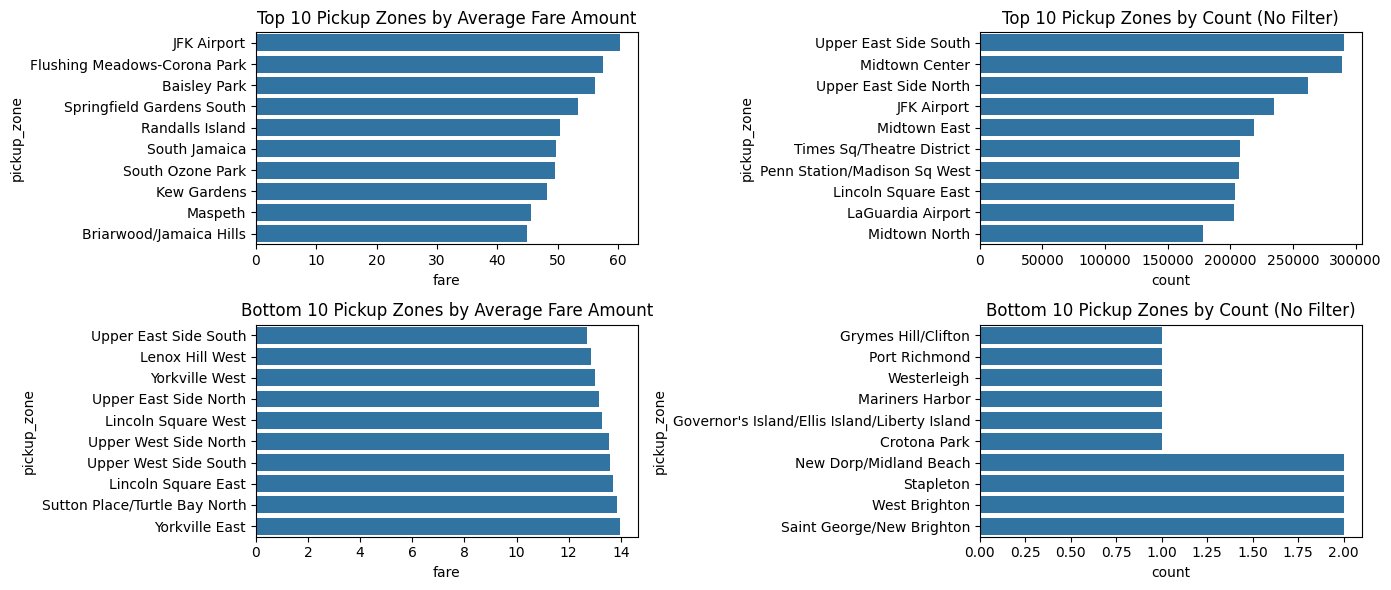

In [ ]:
# table of top pick up zones by average fare amount
query = """
SELECT pickup_zone, AVG(fare_amount) as fare, COUNT(*) as count 
FROM nyc_taxi.yellow_taxi_clean as Y
GROUP BY pickup_zone;
"""
pickup_zone_counts = pd.read_sql(query, db_connection)
pickup_zone_counts = pickup_zone_counts.sort_values(by='count', ascending=False)

print(pickup_zone_counts['count'].describe())
pickup_zone_counts_no_outliers = pickup_zone_counts[pickup_zone_counts['count'] > 100]
pickup_zone_counts_no_filter = pickup_zone_counts.sort_values(by ='count', ascending=False).head(10)
pickup_zone_counts_no_filter_bottom = pickup_zone_counts.sort_values(by ='count', ascending=True).head(10)

pickup_zone_counts_top = pickup_zone_counts_no_outliers.sort_values(by='fare', ascending=False).head(10)
pickup_zone_counts_bottom = pickup_zone_counts_no_outliers.sort_values(by='fare', ascending=True).head(10)
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

sns.barplot(data=pickup_zone_counts_top, x='fare', y='pickup_zone', ax=axes[0, 0])
axes[0,0].set_title('Top 10 Pickup Zones by Average Fare Amount')
sns.barplot(data=pickup_zone_counts_bottom, x='fare', y='pickup_zone', ax=axes[1, 0])
axes[1,0].set_title('Bottom 10 Pickup Zones by Average Fare Amount')

sns.barplot(data=pickup_zone_counts_no_filter, x='count', y='pickup_zone', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Pickup Zones by Count (No Filter)')
sns.barplot(data=pickup_zone_counts_no_filter_bottom, x='count', y='pickup_zone', ax=axes[1, 1])
axes[1, 1].set_title('Bottom 10 Pickup Zones by Count (No Filter)')
plt.tight_layout()
plt.show()




/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/3108889321.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pickup_borough_fare = pd.read_sql(query, db_connection)


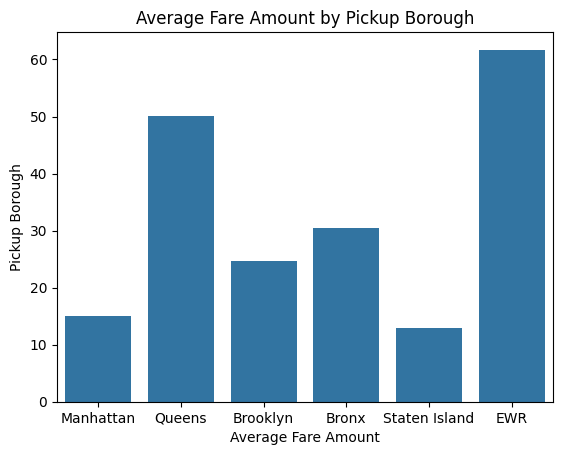

In [ ]:
# pick up borough by average fare amount
query = """
SELECT pickup_borough, AVG(fare_amount) as Average, COUNT(fare_amount) as trip_count FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY AVG(fare_amount) DESC;
"""
pickup_borough_fare = pd.read_sql(query, db_connection)
pickup_borough_fare = pickup_borough_fare.sort_values(by='trip_count', ascending=False)
sns.barplot(data=pickup_borough_fare, x='pickup_borough', y='Average')
plt.title('Average Fare Amount by Pickup Borough')
plt.xlabel('Average Fare Amount')
plt.ylabel('Pickup Borough')
plt.show()

In [ ]:
# weekday vs weekend fare amounts
import scipy.stats as stats
query = """
SELECT day_case, COUNT(*) AS Trip_count, AVG(fare_amount),STD(fare_amount) as std, AVG(Trip_duration) FROM (SELECT *, CASE WHEN DAYOFWEEK(pickup_date) BETWEEN  2 and 6 THEN 'Weekday' ELSE 'Weekend' END AS day_case FROM nyc_taxi.yellow_taxi_clean) AS mini
GROUP BY day_case;
"""
day_counts = pd.read_sql(query, db_connection)
print(day_counts)
meanWeekday, stdWeekday, countWeekday = day_counts['AVG(fare_amount)'][0], day_counts['std'][0], day_counts['Trip_count'][0]
meanWeekend, stdWeekend, countWeekend = day_counts['AVG(fare_amount)'][1], day_counts['std'][1], day_counts['Trip_count'][1]
print(f"Weekday: mean={meanWeekday}, std={stdWeekday}, count={countWeekday}")
print(f"Weekend: mean={meanWeekend}, std={stdWeekend}, count={countWeekend}")

z = (meanWeekday - meanWeekend) / ((stdWeekday**2/countWeekday + stdWeekend**2/countWeekend)**0.5)
print(f"Z-score for difference in average fare amounts between weekdays and weekends: {z}")
print(f"p-value for difference in average fare amounts between weekdays and weekends: {2 * (1 - stats.norm.cdf(abs(z)))}")

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2979252126.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  day_counts = pd.read_sql(query, db_connection)


  day_case  Trip_count  AVG(fare_amount)        std  AVG(Trip_duration)
0  Weekday     4188530         18.068769  14.683820             14.9780
1  Weekend     1657465         18.245725  15.537078             14.1909
Weekday: mean=18.068769, std=14.683820392402533, count=4188530
Weekend: mean=18.245725, std=15.53707768190699, count=1657465
Z-score for difference in average fare amounts between weekdays and weekends: -12.60369216933442
p-value for difference in average fare amounts between weekdays and weekends: 0.0


In [ ]:
# Rainy vs Non-Rainy Days
query = """
SELECT rain_case, COUNT(*) as Trip_count, AVG(fare_amount), AVG(Trip_duration) FROM (SELECT *, CASE WHEN precip > 0 THEN 'Rainy' ELSE 'Non-rainy' END AS rain_case FROM nyc_taxi.yellow_taxi_clean) AS mini
GROUP BY rain_case;
"""
rain_counts = pd.read_sql(query, db_connection)
print(rain_counts)
meanRainy, stdRainy, countRainy = rain_counts['AVG(fare_amount)'][0], rain_counts['AVG(Trip_duration)'][0], rain_counts['Trip_count'][0]
meanNonRainy, stdNonRainy, countNonRainy = rain_counts['AVG(fare_amount)'][1], rain_counts['AVG(Trip_duration)'][1], rain_counts['Trip_count'][1]
print(f"Rainy: mean={meanRainy}, std={stdRainy}, count={countRainy}")
print(f"Non-Rainy: mean={meanNonRainy}, std={stdNonRainy}, count={countNonRainy}")
z = (meanRainy - meanNonRainy) / ((stdRainy**2/countRainy + stdNonRainy**2/countNonRainy)**0.5)
print(f"Z-score for difference in average fare amounts between rainy and non-rainy days: {z}")
print(f"p-value for difference in average fare amounts between rainy and non-rainy days: {2 * (1 - stats.norm.cdf(abs(z)))}")


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/816286346.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rain_counts = pd.read_sql(query, db_connection)


   rain_case  Trip_count  AVG(fare_amount)  AVG(Trip_duration)
0  Non-rainy     3116164         18.266656             14.7661
1      Rainy     2729831         17.950319             14.7420


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2697241503.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trip_duration_fare = pd.read_sql(query, db_connection)


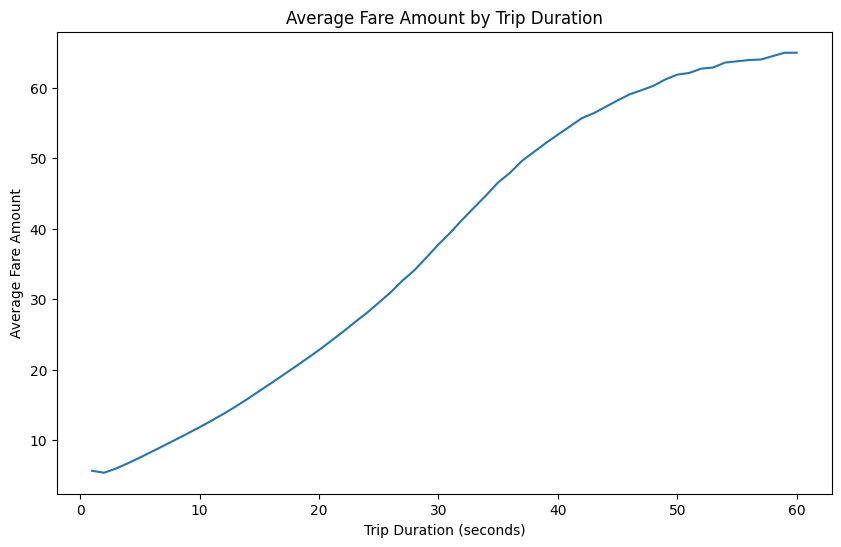

In [ ]:
query = """
SELECT Trip_duration, AVG(fare_amount) FROM nyc_taxi.yellow_taxi_clean
GROUP BY Trip_duration
ORDER BY Trip_duration;
"""
trip_duration_fare = pd.read_sql(query, db_connection)
trip_duration_fare = trip_duration_fare.sort_values(by='Trip_duration')
plt.figure(figsize=(10, 6))
sns.lineplot(data=trip_duration_fare, x='Trip_duration', y='AVG(fare_amount)')
plt.title('Average Fare Amount by Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Average Fare Amount')
plt.show()


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/3937893447.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weekday_weekend_counts = pd.read_sql(query, db_connection)


  pickup_borough  Trip_count  Trip_count_Weekday  Trip_count_Weekend  \
0          Bronx        8627                6423                2204   
1       Brooklyn       38662               29243                9419   
2            EWR          27                  19                   8   
3      Manhattan     5303548             3800353             1503195   
4         Queens      495066              352446              142620   
5  Staten Island          65                  46                  19   

   Avg_fare_Weekday  Avg_fare_Weekend  Avg_duration_Weekday  \
0         31.599721         27.388339               34.7584   
1         24.696103         24.743190               27.2574   
2         63.089474         58.437500               25.7368   
3         15.062328         15.082399               13.2335   
4         49.688424         51.014674               32.4084   
5         12.551957         13.851579               17.8043   

   Avg_duration_Weekend  
0               25.8471  
1

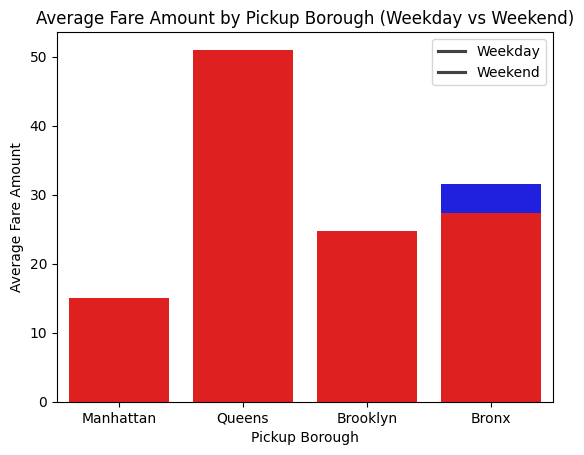

In [ ]:
#weekday vs weekend by borough
query = """
SELECT 
  pickup_borough,
  
  -- Total trip counts
  COUNT(*) AS Trip_count,
  -- Trip counts
  COUNT(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN 1 END) AS Trip_count_Weekday,
  COUNT(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN 1 END) AS Trip_count_Weekend,
  
  -- Average fare amounts
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN fare_amount END) AS Avg_fare_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN fare_amount END) AS Avg_fare_Weekend,
  
  -- Average trip duration
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN Trip_duration END) AS Avg_duration_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN Trip_duration END) AS Avg_duration_Weekend

FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY pickup_borough;
"""
weekday_weekend_counts = pd.read_sql(query, db_connection)
print(weekday_weekend_counts)
weekday_weekend_counts = weekday_weekend_counts.sort_values(by='pickup_borough')
weekday_weekend_counts = weekday_weekend_counts[weekday_weekend_counts['Trip_count'] > 100]  # Filter out low counts for better visualization
weekday_weekend_counts = weekday_weekend_counts.sort_values(by='Trip_count', ascending=False).head(5)
sns.barplot(data=weekday_weekend_counts, x='pickup_borough', y='Avg_fare_Weekday', color='blue')
sns.barplot(data=weekday_weekend_counts, x='pickup_borough', y='Avg_fare_Weekend', color='red')
plt.title('Average Fare Amount by Pickup Borough (Weekday vs Weekend)')
plt.xlabel('Pickup Borough')
plt.ylabel('Average Fare Amount')
plt.legend(['Weekday', 'Weekend'])
plt.show()


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2267345312.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  borough_data = pd.read_sql(borough_query, db_connection)
/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2267345312.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  zone_data = pd.read_sql(zone_query, db_connection)
/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/2267345312.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  service_type_data = pd.read_sql(se

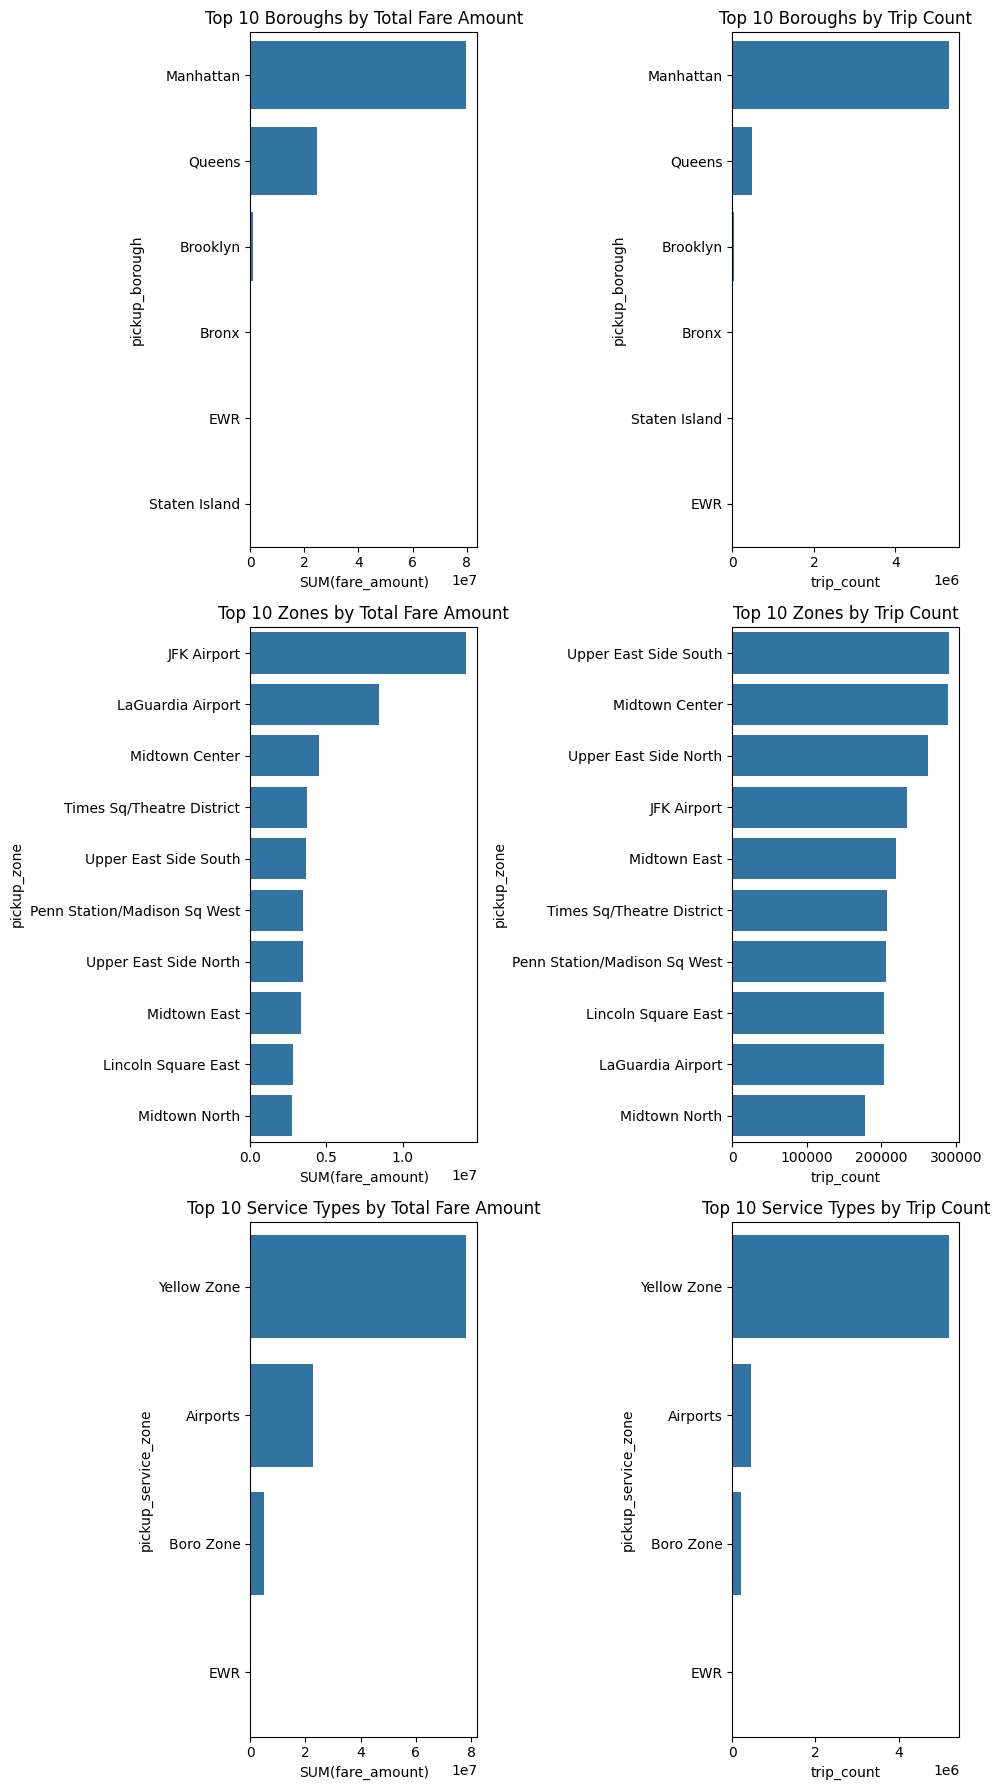

In [ ]:
# Top borough, zone, and service type by average fare amount
borough_query = """
SELECT pickup_borough, SUM(fare_amount), COUNT(*) AS trip_count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY SUM(fare_amount) desc;
"""
zone_query = """
SELECT pickup_zone, SUM(fare_amount), COUNT(*) AS trip_count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_zone
ORDER BY SUM(fare_amount) desc;
"""
service_type_query = """
SELECT pickup_service_zone, SUM(fare_amount), COUNT(*) AS trip_count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_service_zone
ORDER BY SUM(fare_amount) desc;
"""
borough_data = pd.read_sql(borough_query, db_connection)
zone_data = pd.read_sql(zone_query, db_connection)
service_type_data = pd.read_sql(service_type_query, db_connection)

borough_fare = borough_data.sort_values(by='SUM(fare_amount)', ascending=False).head(10)
zone_fare = zone_data.sort_values(by='SUM(fare_amount)', ascending=False).head(10)
service_type_fare = service_type_data.sort_values(by='SUM(fare_amount)', ascending=False).head(10)

borough_count = borough_data.sort_values(by='trip_count', ascending=False).head(10)
zone_count = zone_data.sort_values(by='trip_count', ascending=False).head(10)
service_type_count = service_type_data.sort_values(by='trip_count', ascending=False).head(10)
# Visualizing the top boroughs, zones, and service types by total fare amount and trip count
fig, axes = plt.subplots(3, 2, figsize=(10, 18))
sns.barplot(data=borough_fare, x='SUM(fare_amount)', y='pickup_borough', ax=axes[0, 0])
axes[0,0].set_title('Top 10 Boroughs by Total Fare Amount')
sns.barplot(data=zone_fare, x='SUM(fare_amount)', y='pickup_zone', ax=axes[1, 0])
axes[1,0].set_title('Top 10 Zones by Total Fare Amount')
sns.barplot(data=service_type_fare, x='SUM(fare_amount)', y='pickup_service_zone', ax=axes[2,0])
axes[2,0].set_title('Top 10 Service Types by Total Fare Amount')

sns.barplot(data=borough_count, x='trip_count', y='pickup_borough', ax=axes[0, 1])
axes[0,1].set_title('Top 10 Boroughs by Trip Count')
sns.barplot(data=zone_count, x='trip_count', y='pickup_zone', ax=axes[1, 1])
axes[1,1].set_title('Top 10 Zones by Trip Count')
sns.barplot(data=service_type_count, x='trip_count', y='pickup_service_zone', ax=axes[2,1])
axes[2,1].set_title('Top 10 Service Types by Trip Count')   
plt.tight_layout()
plt.show()  

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_11026/3680365470.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hourly_fare = pd.read_sql(query, db_connection)


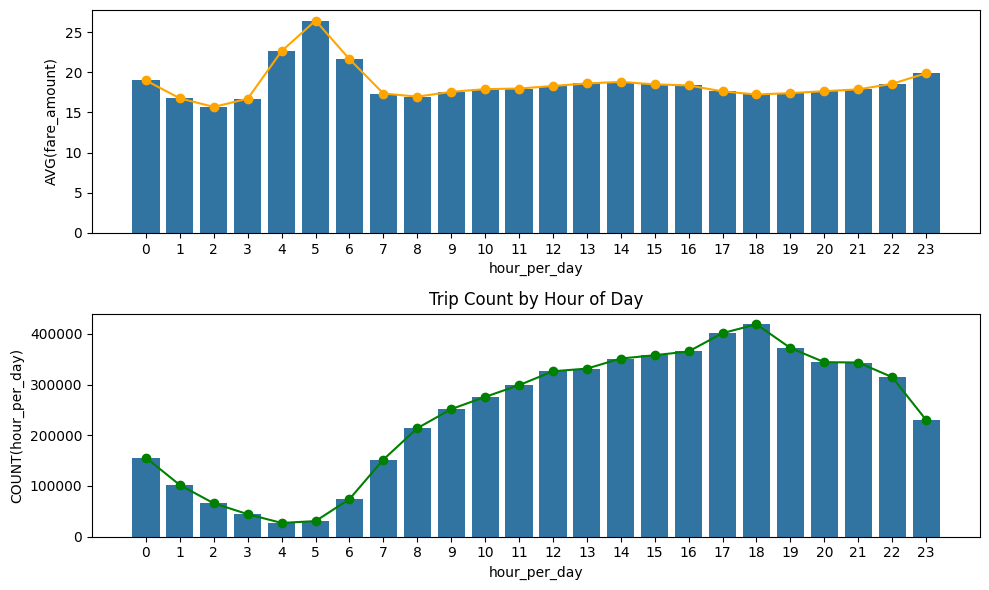

In [ ]:
# hour of day vs average fare amount
query = """
SELECT hour_per_day,AVG(fare_amount), COUNT(hour_per_day) FROM (SELECT *, HOUR(tpep_pickup_datetime) as hour_per_day FROM nyc_taxi.yellow_taxi_clean) as hour_taxi 
GROUP BY hour_per_day;
"""
hourly_fare = pd.read_sql(query, db_connection)
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
sns.barplot(data=hourly_fare, x='hour_per_day', y='AVG(fare_amount)', ax =axes[0])
axes[0].plot(hourly_fare['hour_per_day'], hourly_fare['AVG(fare_amount)'], marker='o', color='orange')
plt.title('Average Fare Amount by Hour of Day')

sns.barplot(data=hourly_fare, x='hour_per_day', y='COUNT(hour_per_day)', ax=axes[1])
axes[1].plot(hourly_fare['hour_per_day'], hourly_fare['COUNT(hour_per_day)'], marker='o', color='green')
plt.title('Trip Count by Hour of Day')
plt.tight_layout()

In [ ]:
# proportion of conditions in my data

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_25598/2677359897.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_fare = pd.read_sql(condition_query, db_connection)


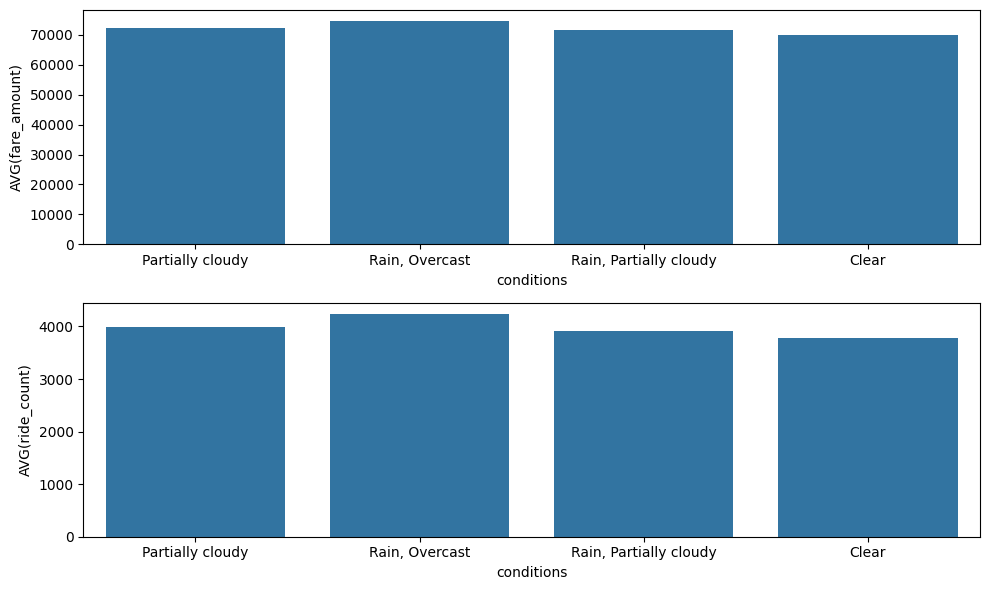

               conditions  AVG(fare_amount)  AVG(ride_count)
0        Partially cloudy      72439.180883        3982.3233
1          Rain, Overcast      74631.793891        4244.3055
2  Rain, Partially cloudy      71641.246389        3916.2556
3                   Clear      70095.759219        3785.2604


In [37]:
# condition vs average fare amount
condition_query = """
SELECT conditions, AVG(fare_amount), AVG(ride_count) FROM (SELECT pickup_date , HOUR(tpep_pickup_datetime) as hour_of_day, conditions, COUNT(*) AS ride_count, SUM(fare_amount) AS fare_amount
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime),conditions) AS hour_taxi
GROUP BY conditions;
"""
condition_fare = pd.read_sql(condition_query, db_connection)

fig, axes = plt.subplots(2,1, figsize=(10, 6))
sns.barplot(data=condition_fare, x='conditions', y='AVG(fare_amount)', ax=axes[0])

sns.barplot(data=condition_fare, x='conditions', y='AVG(ride_count)', ax=axes[1])

plt.tight_layout()
plt.show()

print(condition_fare)


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_40313/2142510570.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_temp_rides = pd.read_sql(time_temp_rides_query, db_connection)


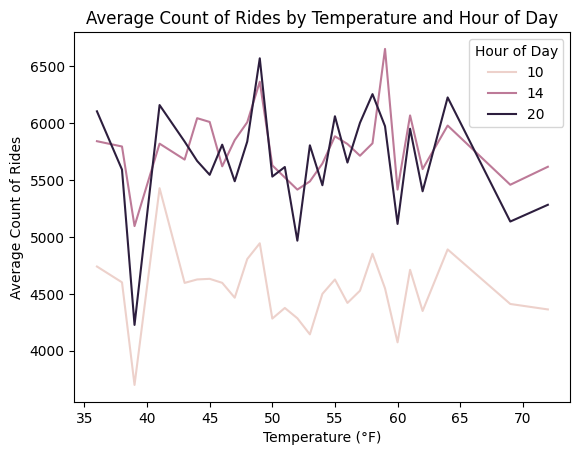

In [4]:
time_temp_rides_query = """ 
SELECT temp, hour_taxi, AVG(count_of_rides), AVG(fare_sum) as avg_fair_sum
FROM (SELECT pickup_date, HOUR(tpep_pickup_datetime) as hour_taxi, ROUND(temp) as temp, COUNT(*) as count_of_rides, SUM(fare_amount) AS fare_sum FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime), ROUND(temp)) AS temp_by_hour
WHERE hour_taxi IN (10,14,20)
GROUP BY temp,hour_taxi
ORDER BY temp, hour_taxi;

"""
time_temp_rides = pd.read_sql(time_temp_rides_query, db_connection)
sns.lineplot(data=time_temp_rides, x='temp', y='AVG(count_of_rides)', hue='hour_taxi')
plt.title('Average Count of Rides by Temperature and Hour of Day')
plt.xlabel('Temperature (°F)')
plt.ylabel('Average Count of Rides')
plt.legend(title='Hour of Day')
plt.show()

# Machine Learning section


In [ ]:
query = """
SELECT   DAYOFWEEK(pickup_date) as Day , HOUR(tpep_pickup_datetime) as hour_of_day,  CASE WHEN DAYOFWEEK(pickup_date) BETWEEN  2 and 6 THEN 0 ELSE 1 END AS is_weekend ,PULocationID, temp, 
	CASE WHEN LOWER(conditions) LIKE '%rain%' THEN 1 ELSE 0 END AS is_rain,
	CASE WHEN LOWER(conditions) LIKE '%overcast%' THEN 1 ELSE 0 END AS is_overcast,
	CASE WHEN LOWER(conditions) LIKE '%partially cloudy%' THEN 1 ELSE 0 END AS is_partially_cloudy,
	CASE WHEN LOWER(conditions) LIKE '%clear%' THEN 1 ELSE 0 END AS is_clear,
    COUNT(*) as ride_count
FROM  nyc_taxi.yellow_taxi_clean
GROUP BY  DAYOFWEEK(pickup_date), HOUR(tpep_pickup_datetime), PULocationID, LOWER(conditions), temp, CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 and 6 THEN 0 ELSE 1 END,
	CASE WHEN LOWER(conditions) LIKE '%rain%' THEN 1 ELSE 0 END,
	CASE WHEN LOWER(conditions) LIKE '%overcast%' THEN 1 ELSE 0 END,
	CASE WHEN LOWER(conditions) LIKE '%partially cloudy%' THEN 1 ELSE 0 END,
	CASE WHEN LOWER(conditions) LIKE '%clear%' THEN 1 ELSE 0 END
ORDER BY  DAYOFWEEK(pickup_date), hour_of_day, PULocationID;
"""
taxi_data = pd.read_sql(query, db_connection)


/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_25598/857241012.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  taxi_data = pd.read_sql(query, db_connection)


In [20]:

print(taxi_data.info())
print(taxi_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134604 entries, 0 to 134603
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Day                  134604 non-null  int64  
 1   hour_of_day          134604 non-null  int64  
 2   is_weekend           134604 non-null  int64  
 3   PULocationID         134604 non-null  int64  
 4   temp                 134604 non-null  float64
 5   is_rain              134604 non-null  int64  
 6   is_overcast          134604 non-null  int64  
 7   is_partially_cloudy  134604 non-null  int64  
 8   is_clear             134604 non-null  int64  
 9   ride_count           134604 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 10.3 MB
None
                 Day    hour_of_day    is_weekend   PULocationID  \
count  134604.000000  134604.000000  134604.00000  134604.000000   
mean        3.959303      11.888146       0.27809     139.934170   
std         1.999

In [24]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
x = pd.concat([taxi_data['Day'], taxi_data['hour_of_day'], taxi_data['is_weekend'], taxi_data['PULocationID'], taxi_data['temp'], taxi_data['is_rain'], taxi_data['is_overcast'], taxi_data['is_partially_cloudy'], taxi_data['is_clear']], axis=1)
y = taxi_data['ride_count']
train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state= 67)



Mean Squared Error: 5122.204538841225
R^2 Score: 0.09337281059433533


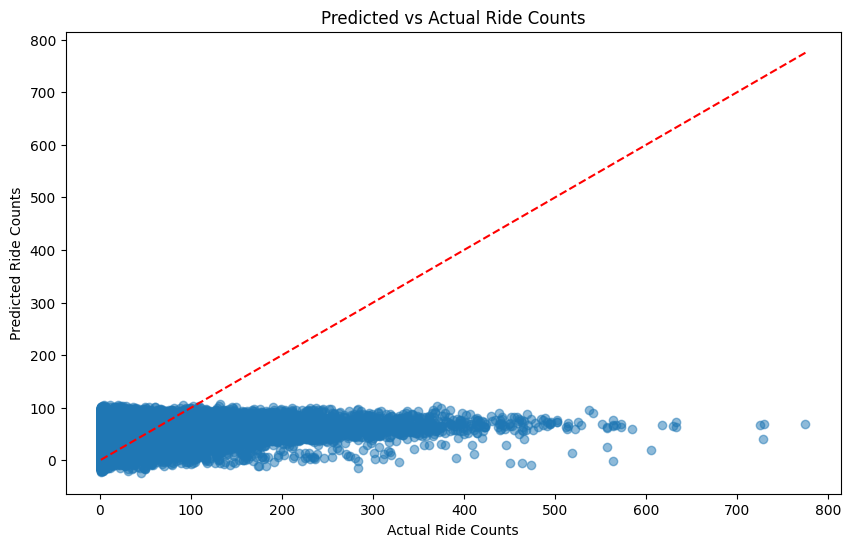

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Create a linear regression model
model = LinearRegression()
# Fit the model to the training data
model.fit(train_data, train_labels)
# Predict on the test data
predictions = model.predict(test_data)
# Evaluate the model
mse = mean_squared_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()

XGBoost Mean Squared Error: 322.6585693359375
XGBoost R^2 Score: 0.9428896307945251


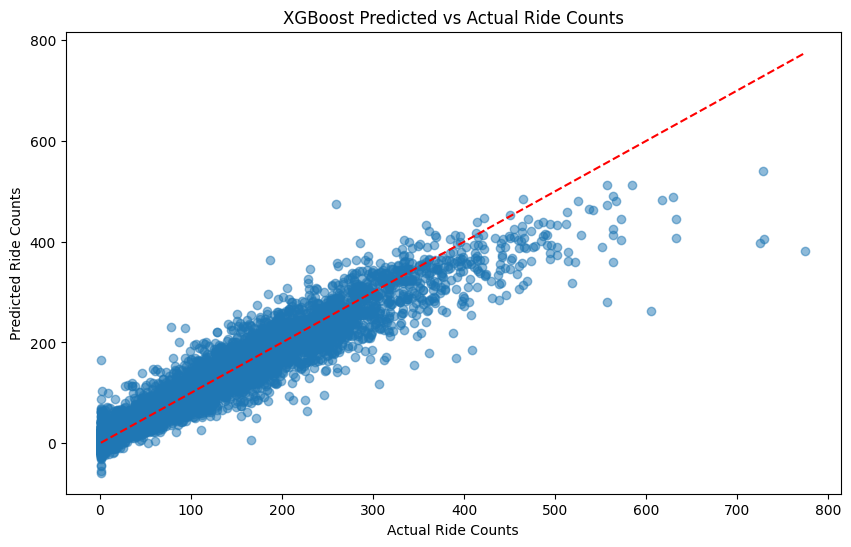

In [28]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
# Create an XGBoost regression model
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=67)
# Fit the model to the training data
xgb_model.fit(train_scaled, train_labels)
# Predict on the test data
xgb_predictions = xgb_model.predict(test_scaled)
# Evaluate the model
xgb_mse = mean_squared_error(test_labels, xgb_predictions)
xgb_r2 = r2_score(test_labels, xgb_predictions)
print(f'XGBoost Mean Squared Error: {xgb_mse}')
print(f'XGBoost R^2 Score: {xgb_r2}')
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, xgb_predictions, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='red', linestyle='--')
plt.title('XGBoost Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()

In [ ]:
#check for overfitting
# Evaluate the model on the training set
train_predictions = xgb_model.predict(train_scaled)
train_mse = mean_squared_error(train_labels, train_predictions)
train_r2 = r2_score(train_labels, train_predictions)
print(f'XGBoost Training Mean Squared Error: {train_mse}')
print(f'XGBoost Training R^2 Score: {train_r2}')
# Evaluate the model on the test set
test_predictions = xgb_model.predict(test_scaled)
test_mse = mean_squared_error(test_labels, test_predictions)
test_r2 = r2_score(test_labels, test_predictions)
print(f'XGBoost Test Mean Squared Error: {test_mse}')
print(f'XGBoost Test R^2 Score: {test_r2}')
"""
Not overfitting if the training and test scores are similar as train MSE and 
r2 score are close to the test MSE and r2 score.
If the training scores are significantly better than the test scores or if the
training R^2 score is very high (close to 1) while the test R^2 score is much lower,
it indicates overfitting.
"""


XGBoost Training Mean Squared Error: 267.5396423339844
XGBoost Training R^2 Score: 0.9510515332221985
XGBoost Test Mean Squared Error: 322.6585693359375
XGBoost Test R^2 Score: 0.9428896307945251
